

<font size = "5"> **Chapter 4: [Spectroscopy](CH4-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



# Analysis of Core-Loss Spectra

<font size = "5"> **This notebook does not work in Google Colab** </font>


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_09-Analyse_Core_Loss.ipynb)
 


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Load important packages

### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('sidpy') < '0.0.5':
    print('installing sidpy')
    !{sys.executable} -m pip install  --upgrade sidpy -q    
if test_package('pyTEMlib') < '0.2021.4.20':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [1]:
%pylab --no-import-all notebook
%gui qt

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 
import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2021_04_22'

Populating the interactive namespace from numpy and matplotlib


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


pyTEM version:  0.2021.04.20


## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:351: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


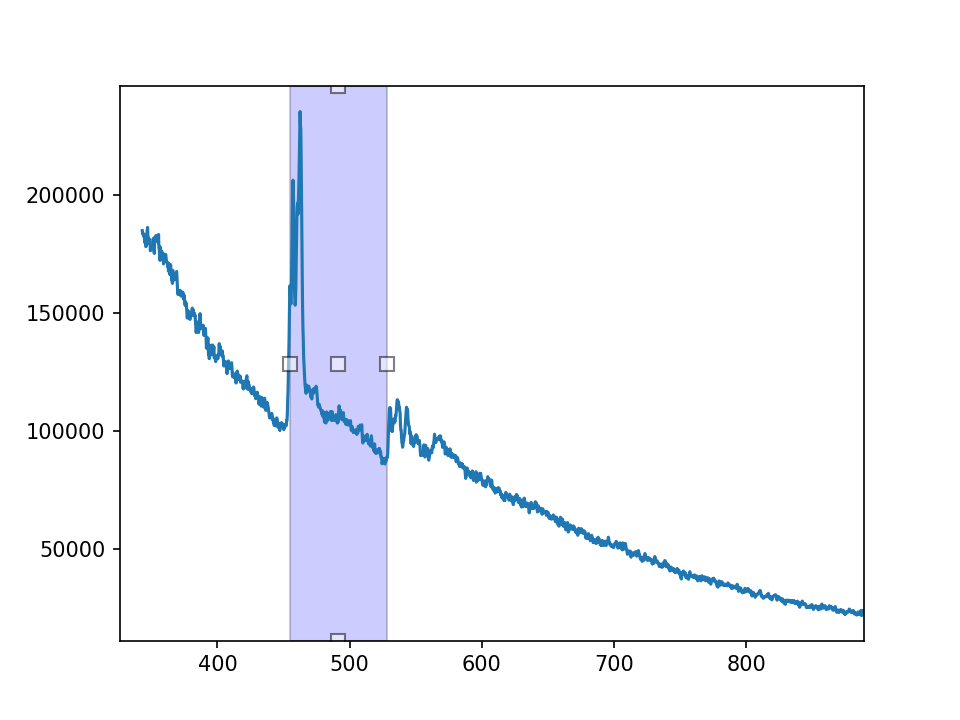

In [3]:
# -----Input -------#
load_example = True

try:
    main_dataset.h5_dataset.file.close()
except:
    pass

if load_example:
    main_dataset = ft.open_file('../example_data/EELS_STO.dm3')
else:
    main_dataset = ft.open_file()

current_channel = main_dataset.h5_dataset.parent

if 'experiment' not in main_dataset.metadata:
    main_dataset.metadata['experiment']= eels.read_dm3_eels_info(main_dataset.original_metadata)

eels.set_previous_quantification(main_dataset)

# US 200 does not set acceleration voltage correctly.
# comment out next line  for other microscopes
# current_dataset.metadata['experiment']['acceleration_voltage'] = 200000

info = ieels.InfoDialog(main_dataset)

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

<IPython.core.display.Javascript object>


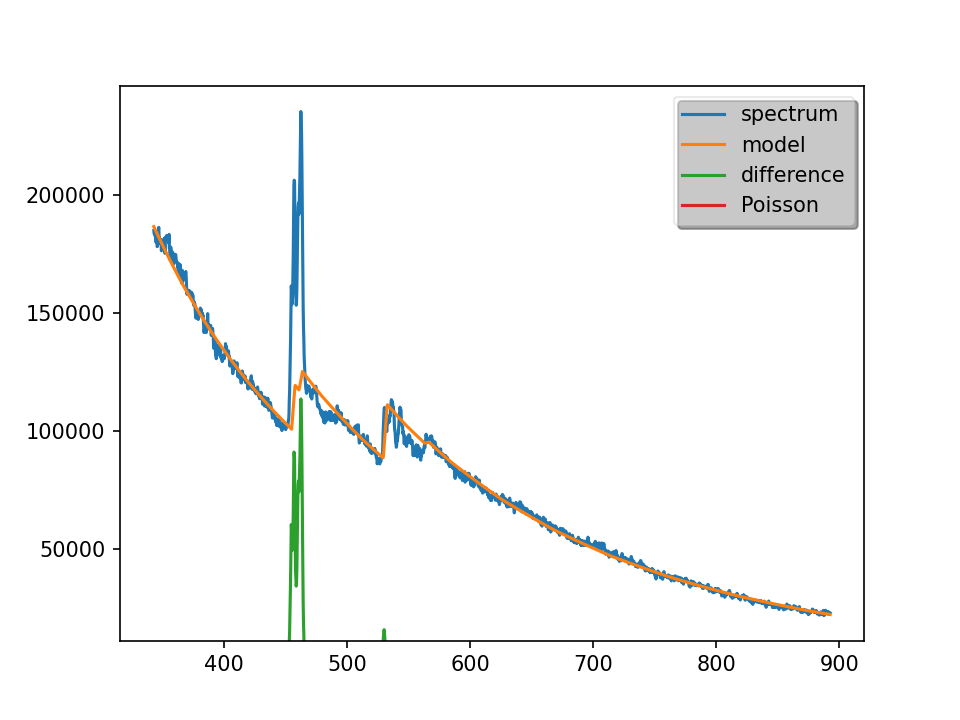

In [4]:
# current_dataset.metadata['edges'] = {'0': {}, 'model': {}}
composition = ieels.CompositionDialog(main_dataset)

### Output of Results

In [9]:
edges = main_dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])
        
print('Relative chemical composition of ', main_dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges


Relative chemical composition of  EELS_STO
Ti: 21.3 %
O: 78.7 %


### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [6]:
current_group = main_dataset.h5_dataset.parent.parent
if 'Log_000' in current_group:
    del current_group['Log_000']

log_group = current_group.create_group('Log_000')
log_group['analysis'] = 'EELS_quantification'
log_group['EELS_quantification'] = ''
flat_dict = ft.flatten_dict(main_dataset.metadata)
if  'peak_fit-peak_out_list' in flat_dict: 
    del flat_dict['peak_fit-peak_out_list']
for key, item in flat_dict.items():
    if not key == 'peak_fit-peak_out_list':
        log_group.attrs[key]= item
current_group.file.flush()
ft.h5_tree(main_dataset.h5_dataset.file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ EELS_STO
      --------
      ├ EELS_STO
      ├ __dict__
        --------
      ├ _axes
        -----
      ├ _original_metadata
        ------------------
      ├ energy_loss
      ├ original_metadata
        -----------------
    ├ Log_000
      -------
      ├ EELS_quantification
      ├ analysis


## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (2 iterations are ususally sufficient) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).


<IPython.core.display.Javascript object>


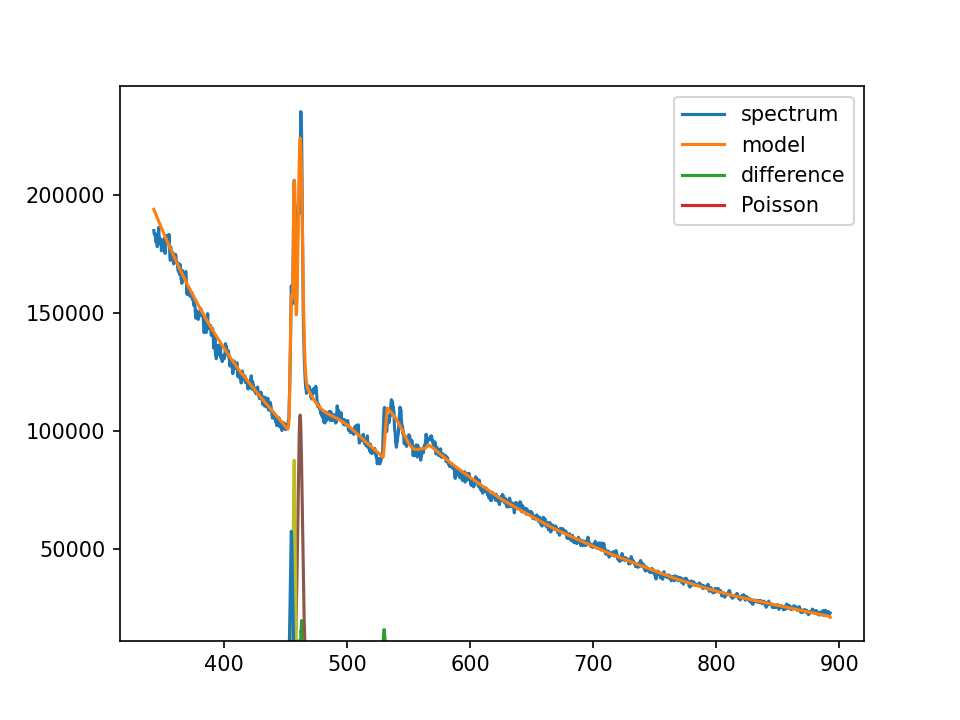

In [7]:
peak_dialog = ieels.PeakFitDialog(main_dataset)

### Output

In [8]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

peak  0: position:   506.5, area: -6722143.802 associated edge: Ti-L2
peak  1: position:   933.7, area: -4819176.064 associated edge: 
peak  2: position:   515.9, area:  3289440.959 associated edge: 
peak  3: position:   493.8, area:  2197645.853 associated edge: Ti-L2
peak  4: position:   905.3, area:  1857244.132 associated edge: 
peak  5: position:  1157.2, area:  1694326.260 associated edge: 
peak  6: position:   461.9, area:  1039384.757 associated edge: Ti-L2
peak  7: position:   853.9, area:   476364.383 associated edge: 
peak  8: position:   457.1, area:   348689.573 associated edge: Ti-L3


### Log Data

In [10]:
current_group = main_dataset.h5_dataset.parent.parent
if 'Log_001' in current_group:
    del current_group['Log_001']
    
log_group = current_group.create_group('Log_001')
log_group['analysis'] = 'ELNES_fit'
log_group['ELNES_fit'] = ''
metadata = ft.flatten_dict(main_dataset.metadata)

if  'peak_fit-peak_out_list' in flat_dict: 
    del flat_dict['peak_fit-peak_out_list']
for key, item in metadata.items():
    if not key == 'peak_fit-peak_out_list':
        log_group.attrs[key]= item
current_group.file.flush()

print('Logged Data of ', main_dataset.title)
for key in current_group:
    if 'Log_' in key:
        if 'analysis' in current_group[key]:
            print(f" {key}: {current_group[key]['analysis'][()]}")

Logged Data of  1EELS Acquire (high_loss)
 Log_000: b'EELS_quantification'
 Log_001: b'ELNES_fit'


## Close File
File needs to be closed to be used with other notebooks

In [11]:
main_dataset.h5_dataset.file.close()

## Navigation
